# Library

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications import MobileNetV2

# Others
import shutil
import random

# Load dataset

In [4]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Apple/train",
    label_mode="categorical",
    class_names=['Apple Black rot', 'Apple Scab Leaf', 'Apple leaf Healthy', 'Apple rust leaf'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Apple/valid",
    label_mode="categorical",
    class_names=['Apple Black rot', 'Apple Scab Leaf', 'Apple leaf Healthy', 'Apple rust leaf'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 8014 files belonging to 4 classes.
==========================Validation Data====================
Found 1943 files belonging to 4 classes.


In [5]:
# All images will be rescaled by 1./256. and Augmented
train_datagen = ImageDataGenerator(rescale = 1.0/256.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("Dataset/Apple/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("Dataset/Apple/valid",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 8014 images belonging to 4 classes.
Found 1943 images belonging to 4 classes.


# List Resource

In [6]:
# Check GPU
!nvidia-smi

Fri May 26 23:07:19 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 532.03                 Driver Version: 532.03       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 L...  WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   54C    P0               40W /  N/A|   4595MiB /  6144MiB |      6%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Modelling With Augmentation

## MobileNet V2 Model 1

In [9]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Apple_MobileNetV2_model1_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [10]:
# Define DIY Model
MobileNetV2_model = tf.keras.models.Sequential([
    # MobileNetV2121 Layer
    MobileNetV2(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(4, activation='softmax') 
  ])


# Compile Model
MobileNetV2_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
MobileNetV2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 2,586,948
Trainable params: 2,552,836
Non-

In [11]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_MobileNetV2_model_1 = MobileNetV2_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
401/401 [==============================] - ETA: 0s - loss: 0.4415 - accuracy: 0.9138
Epoch 1: val_accuracy improved from -inf to 0.53989, saving model to Apple_MobileNetV2_model1_Based_Augmented


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model1_Based_Augmented\assets


401/401 [==============================] - 93s 212ms/step - loss: 0.4415 - accuracy: 0.9138 - val_loss: 1.9797 - val_accuracy: 0.5399 - lr: 0.0010
Epoch 2/100
401/401 [==============================] - ETA: 0s - loss: 0.1443 - accuracy: 0.9586
Epoch 2: val_accuracy improved from 0.53989 to 0.74164, saving model to Apple_MobileNetV2_model1_Based_Augmented


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model1_Based_Augmented\assets


401/401 [==============================] - 81s 202ms/step - loss: 0.1443 - accuracy: 0.9586 - val_loss: 0.7524 - val_accuracy: 0.7416 - lr: 0.0010
Epoch 3/100
401/401 [==============================] - ETA: 0s - loss: 0.0935 - accuracy: 0.9704
Epoch 3: val_accuracy did not improve from 0.74164
401/401 [==============================] - 66s 164ms/step - loss: 0.0935 - accuracy: 0.9704 - val_loss: 2.5967 - val_accuracy: 0.6166 - lr: 0.0010
Epoch 4/100
401/401 [==============================] - ETA: 0s - loss: 0.1129 - accuracy: 0.9654
Epoch 4: val_accuracy did not improve from 0.74164
401/401 [==============================] - 66s 164ms/step - loss: 0.1129 - accuracy: 0.9654 - val_loss: 1.2373 - val_accuracy: 0.7015 - lr: 0.0010
Epoch 5/100
401/401 [==============================] - ETA: 0s - loss: 0.1110 - accuracy: 0.9694
Epoch 5: val_accuracy did not improve from 0.74164
401/401 [==============================] - 73s 182ms/step - loss: 0.1110 - accuracy: 0.9694 - val_loss: 1.5603 - va

INFO:tensorflow:Assets written to: Apple_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model1_Based_Augmented\assets


401/401 [==============================] - 88s 220ms/step - loss: 0.1023 - accuracy: 0.9669 - val_loss: 1.1006 - val_accuracy: 0.7627 - lr: 0.0010
Epoch 7/100
401/401 [==============================] - ETA: 0s - loss: 0.0797 - accuracy: 0.9748
Epoch 7: val_accuracy did not improve from 0.76274

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
401/401 [==============================] - 69s 171ms/step - loss: 0.0797 - accuracy: 0.9748 - val_loss: 1.5888 - val_accuracy: 0.6716 - lr: 0.0010
Epoch 8/100
401/401 [==============================] - ETA: 0s - loss: 0.0371 - accuracy: 0.9883
Epoch 8: val_accuracy improved from 0.76274 to 0.95317, saving model to Apple_MobileNetV2_model1_Based_Augmented


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model1_Based_Augmented\assets


401/401 [==============================] - 82s 205ms/step - loss: 0.0371 - accuracy: 0.9883 - val_loss: 0.1753 - val_accuracy: 0.9532 - lr: 1.0000e-04
Epoch 9/100
401/401 [==============================] - ETA: 0s - loss: 0.0277 - accuracy: 0.9915
Epoch 9: val_accuracy improved from 0.95317 to 0.99022, saving model to Apple_MobileNetV2_model1_Based_Augmented


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model1_Based_Augmented\assets


401/401 [==============================] - 86s 214ms/step - loss: 0.0277 - accuracy: 0.9915 - val_loss: 0.0334 - val_accuracy: 0.9902 - lr: 1.0000e-04
Epoch 10/100
401/401 [==============================] - ETA: 0s - loss: 0.0227 - accuracy: 0.9931
Epoch 10: val_accuracy improved from 0.99022 to 0.99794, saving model to Apple_MobileNetV2_model1_Based_Augmented


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model1_Based_Augmented\assets


401/401 [==============================] - 85s 211ms/step - loss: 0.0227 - accuracy: 0.9931 - val_loss: 0.0078 - val_accuracy: 0.9979 - lr: 1.0000e-04
Epoch 11/100
401/401 [==============================] - ETA: 0s - loss: 0.0180 - accuracy: 0.9936
Epoch 11: val_accuracy improved from 0.99794 to 1.00000, saving model to Apple_MobileNetV2_model1_Based_Augmented


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model1_Based_Augmented\assets


401/401 [==============================] - 85s 211ms/step - loss: 0.0180 - accuracy: 0.9936 - val_loss: 0.0010 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 12/100
401/401 [==============================] - ETA: 0s - loss: 0.0155 - accuracy: 0.9945
Epoch 12: val_accuracy did not improve from 1.00000
401/401 [==============================] - 68s 169ms/step - loss: 0.0155 - accuracy: 0.9945 - val_loss: 0.0041 - val_accuracy: 0.9990 - lr: 1.0000e-04
Epoch 13/100
401/401 [==============================] - ETA: 0s - loss: 0.0138 - accuracy: 0.9943
Epoch 13: val_accuracy did not improve from 1.00000
401/401 [==============================] - 70s 174ms/step - loss: 0.0138 - accuracy: 0.9943 - val_loss: 0.0017 - val_accuracy: 0.9995 - lr: 1.0000e-04
Epoch 14/100
401/401 [==============================] - ETA: 0s - loss: 0.0220 - accuracy: 0.9923
Epoch 14: val_accuracy did not improve from 1.00000
401/401 [==============================] - 68s 169ms/step - loss: 0.0220 - accuracy: 0.9923 - val

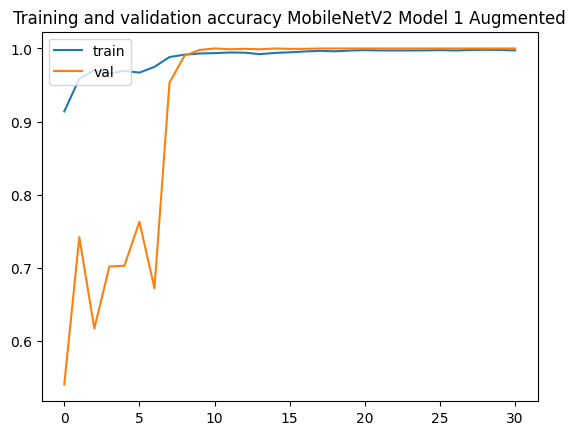

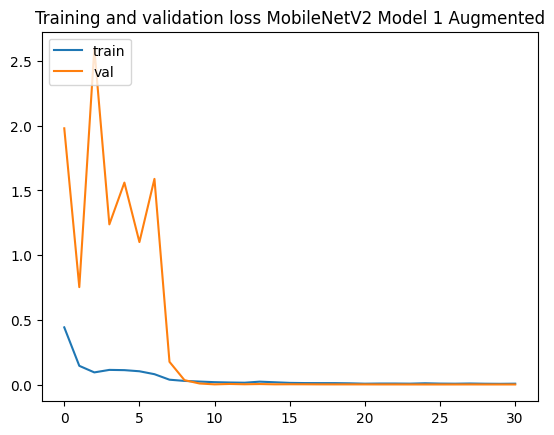

In [12]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_MobileNetV2_model_1.history['accuracy' ]
val_acc  = history_MobileNetV2_model_1.history['val_accuracy' ]
loss     = history_MobileNetV2_model_1.history['loss' ]
val_loss = history_MobileNetV2_model_1.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy MobileNetV2 Model 1 Augmented')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss MobileNetV2 Model 1 Augmented')
plt.legend(['train', 'val'], loc='upper left')

## MobileNetV2 Model 2

In [13]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Apple_MobileNetV2_model2_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [14]:
# Define DIY Model
MobileNetV2_model_2 = tf.keras.models.Sequential([
    # MobileNetV2 Layer
    MobileNetV2(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Average Pooling Layer
    tf.keras.layers.GlobalAveragePooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(4, activation='softmax') 
  ])


# Compile Model
MobileNetV2_model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
MobileNetV2_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 2,586,948
Trainable params: 2,552,836
No

In [15]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_MobileNetV2_model_2 = MobileNetV2_model_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
401/401 [==============================] - ETA: 0s - loss: 0.2428 - accuracy: 0.9244
Epoch 1: val_accuracy improved from -inf to 0.27741, saving model to Apple_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Augmented\assets


401/401 [==============================] - 84s 201ms/step - loss: 0.2428 - accuracy: 0.9244 - val_loss: 13.6828 - val_accuracy: 0.2774 - lr: 0.0010
Epoch 2/100
401/401 [==============================] - ETA: 0s - loss: 0.1343 - accuracy: 0.9588
Epoch 2: val_accuracy improved from 0.27741 to 0.50232, saving model to Apple_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Augmented\assets


401/401 [==============================] - 79s 196ms/step - loss: 0.1343 - accuracy: 0.9588 - val_loss: 9.3564 - val_accuracy: 0.5023 - lr: 0.0010
Epoch 3/100
401/401 [==============================] - ETA: 0s - loss: 0.1052 - accuracy: 0.9667
Epoch 3: val_accuracy did not improve from 0.50232
401/401 [==============================] - 65s 162ms/step - loss: 0.1052 - accuracy: 0.9667 - val_loss: 7.5835 - val_accuracy: 0.4359 - lr: 0.0010
Epoch 4/100
401/401 [==============================] - ETA: 0s - loss: 0.0928 - accuracy: 0.9699
Epoch 4: val_accuracy improved from 0.50232 to 0.55687, saving model to Apple_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Augmented\assets


401/401 [==============================] - 80s 199ms/step - loss: 0.0928 - accuracy: 0.9699 - val_loss: 3.1802 - val_accuracy: 0.5569 - lr: 0.0010
Epoch 5/100
401/401 [==============================] - ETA: 0s - loss: 0.0784 - accuracy: 0.9744
Epoch 5: val_accuracy improved from 0.55687 to 0.92229, saving model to Apple_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Augmented\assets


401/401 [==============================] - 83s 207ms/step - loss: 0.0784 - accuracy: 0.9744 - val_loss: 0.4157 - val_accuracy: 0.9223 - lr: 0.0010
Epoch 6/100
401/401 [==============================] - ETA: 0s - loss: 0.0888 - accuracy: 0.9745
Epoch 6: val_accuracy did not improve from 0.92229
401/401 [==============================] - 67s 166ms/step - loss: 0.0888 - accuracy: 0.9745 - val_loss: 0.4283 - val_accuracy: 0.8919 - lr: 0.0010
Epoch 7/100
401/401 [==============================] - ETA: 0s - loss: 0.0702 - accuracy: 0.9789
Epoch 7: val_accuracy did not improve from 0.92229
401/401 [==============================] - 66s 165ms/step - loss: 0.0702 - accuracy: 0.9789 - val_loss: 0.4526 - val_accuracy: 0.9089 - lr: 0.0010
Epoch 8/100
401/401 [==============================] - ETA: 0s - loss: 0.0779 - accuracy: 0.9752
Epoch 8: val_accuracy did not improve from 0.92229
401/401 [==============================] - 67s 167ms/step - loss: 0.0779 - accuracy: 0.9752 - val_loss: 1.5158 - va

INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Augmented\assets


401/401 [==============================] - 82s 204ms/step - loss: 0.0296 - accuracy: 0.9898 - val_loss: 0.1761 - val_accuracy: 0.9619 - lr: 1.0000e-04
Epoch 13/100
401/401 [==============================] - ETA: 0s - loss: 0.0245 - accuracy: 0.9916
Epoch 13: val_accuracy improved from 0.96191 to 0.98353, saving model to Apple_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Augmented\assets


401/401 [==============================] - 84s 209ms/step - loss: 0.0245 - accuracy: 0.9916 - val_loss: 0.0821 - val_accuracy: 0.9835 - lr: 1.0000e-04
Epoch 14/100
401/401 [==============================] - ETA: 0s - loss: 0.0217 - accuracy: 0.9938
Epoch 14: val_accuracy improved from 0.98353 to 0.99846, saving model to Apple_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Augmented\assets


401/401 [==============================] - 83s 206ms/step - loss: 0.0217 - accuracy: 0.9938 - val_loss: 0.0057 - val_accuracy: 0.9985 - lr: 1.0000e-04
Epoch 15/100
401/401 [==============================] - ETA: 0s - loss: 0.0200 - accuracy: 0.9925
Epoch 15: val_accuracy did not improve from 0.99846
401/401 [==============================] - 69s 171ms/step - loss: 0.0200 - accuracy: 0.9925 - val_loss: 0.0074 - val_accuracy: 0.9979 - lr: 1.0000e-04
Epoch 16/100
401/401 [==============================] - ETA: 0s - loss: 0.0183 - accuracy: 0.9930
Epoch 16: val_accuracy improved from 0.99846 to 0.99897, saving model to Apple_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Augmented\assets


401/401 [==============================] - 83s 206ms/step - loss: 0.0183 - accuracy: 0.9930 - val_loss: 0.0038 - val_accuracy: 0.9990 - lr: 1.0000e-04
Epoch 17/100
401/401 [==============================] - ETA: 0s - loss: 0.0170 - accuracy: 0.9941
Epoch 17: val_accuracy did not improve from 0.99897
401/401 [==============================] - 68s 170ms/step - loss: 0.0170 - accuracy: 0.9941 - val_loss: 0.0020 - val_accuracy: 0.9990 - lr: 1.0000e-04
Epoch 18/100
401/401 [==============================] - ETA: 0s - loss: 0.0175 - accuracy: 0.9948
Epoch 18: val_accuracy improved from 0.99897 to 1.00000, saving model to Apple_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Augmented\assets


401/401 [==============================] - 83s 207ms/step - loss: 0.0175 - accuracy: 0.9948 - val_loss: 2.9708e-04 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 19/100
401/401 [==============================] - ETA: 0s - loss: 0.0144 - accuracy: 0.9951
Epoch 19: val_accuracy did not improve from 1.00000
401/401 [==============================] - 104s 259ms/step - loss: 0.0144 - accuracy: 0.9951 - val_loss: 0.0046 - val_accuracy: 0.9985 - lr: 1.0000e-04
Epoch 20/100
401/401 [==============================] - ETA: 0s - loss: 0.0159 - accuracy: 0.9949
Epoch 20: val_accuracy did not improve from 1.00000
401/401 [==============================] - 74s 184ms/step - loss: 0.0159 - accuracy: 0.9949 - val_loss: 0.0055 - val_accuracy: 0.9985 - lr: 1.0000e-04
Epoch 21/100
401/401 [==============================] - ETA: 0s - loss: 0.0130 - accuracy: 0.9951
Epoch 21: val_accuracy did not improve from 1.00000
401/401 [==============================] - 67s 167ms/step - loss: 0.0130 - accuracy: 0.9951 

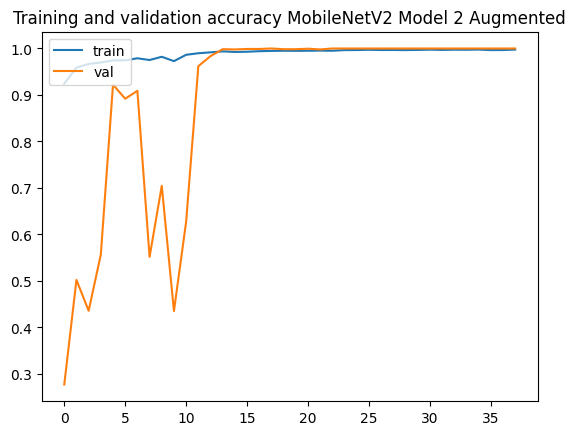

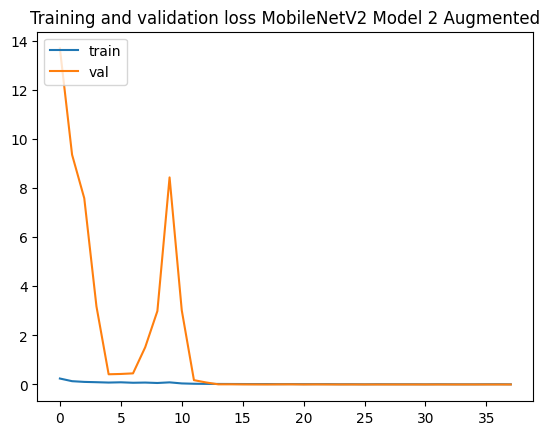

In [16]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_MobileNetV2_model_2.history['accuracy' ]
val_acc  = history_MobileNetV2_model_2.history['val_accuracy' ]
loss     = history_MobileNetV2_model_2.history['loss' ]
val_loss = history_MobileNetV2_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy MobileNetV2 Model 2 Augmented')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss MobileNetV2 Model 2 Augmented')
plt.legend(['train', 'val'], loc='upper left')